In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision import transforms
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
'''
This method is for counting the number of images per class
params: Data directory that holds multiple photos. The folder name should be the class name for use in ImageGenerator (Kears)
output: It will print the class name and the total number of images per class
'''
def count_images_per_class(directory):
    for folder in os.listdir(directory):
        count = 0
        for image in os.listdir(os.path.join(directory, folder)):
            count +=1
        print("Number of images in Class {} are {}".format(folder, count))
    

In [3]:
# Look at the classes that are avalialbe and load the unedited data
RAW_DATA_DIR = "../input/cifar10-pngs-in-folders/cifar10/"
RAW_TRAIN_DIR = os.path.join(RAW_DATA_DIR, 'train/')
RAW_TEST_DIR = os.path.join(RAW_DATA_DIR, 'test/')
count_images_per_class(RAW_TRAIN_DIR)

Number of images in Class automobile are 5000
Number of images in Class frog are 5000
Number of images in Class deer are 5000
Number of images in Class airplane are 5000
Number of images in Class truck are 5000
Number of images in Class ship are 5000
Number of images in Class dog are 5000
Number of images in Class horse are 5000
Number of images in Class bird are 5000
Number of images in Class cat are 5000


I need to take half of the image for three of the classes to meet the data contraints. 
However this will make a data imbalance if I use the original set of data for the other classes.
So I cleaned the dataset by removing 50% of every training set to ensure that there is no data imbalances 
There are a few ways to deal with an umbalanced dataset. 
1. Over sampling the classes with fewer datapoints (Making copies of the images that are lower randomly).
2. Under sampling take fewer images from the classes that have more image. (Remove randomly seleted images) 
3. SMOTE (Synthetic Minority Over-Sampling Technique. Artifically creates samples from the minority classes using KNN of each sample. (Does not really work with images)
<br>
<br>
I decided to go with Under sampling as this will be pretty easy and will still give me 2500 images per class which will be good enough for a simple classification in the end.  

In [4]:
# Use cleaned dataset
DATA_DIR = "../input/cleanedcifar10/cifar10_cleaned/cifar10/"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
# Now count the number of images that remain for each class to ensure a blanced dataset
count_images_per_class(TRAIN_DIR)

Number of images in Class automobile are 2500
Number of images in Class frog are 2500
Number of images in Class deer are 2500
Number of images in Class airplane are 2500
Number of images in Class truck are 2500
Number of images in Class ship are 2500
Number of images in Class dog are 2500
Number of images in Class horse are 2500
Number of images in Class bird are 2500
Number of images in Class cat are 2500


In [5]:
#Basic Transforms
SIZE = (32,32) # Resize the image to this shape
# Test and basic transform. This will reshape and then transform the raw image into a tensor for pytorch
basic = transforms.Compose([transforms.Resize(SIZE),
                            transforms.ToTensor()])

# Normalized transforms (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) retrived from here https://github.com/kuangliu/pytorch-cifar/issues/19
mean = (0.4914, 0.4822, 0.4465) # Mean
std = (0.247, 0.243, 0.261) # Standard deviation
# This will transform the image to the Size and then normalize the image
norm_tran = transforms.Compose([transforms.Resize(SIZE),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=mean, std=std)])

#Simple Data Augmentation
# Data augmentations
'''
Randomly flip the images both virtically and horizontally this will cover and orientation for images
Randomly rotate the image by 15. This will give images even more orientation than before but with limiting the black board issue of rotations
Random Resie and crop this will resize the image and remove any excess to act like a zoom feature
Normalize each image and make it a tensor
'''
aug_tran = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(15),
                               transforms.RandomResizedCrop(SIZE, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=3),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])

In [6]:
# Create Dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=aug_tran)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=norm_tran) #No augmentation for testing sets

In [7]:
# Helper Function to show a tensor image in matlibplot.
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [8]:
# Data loaders
# Parameters for setting up data loaders
BATCH_SIZE = 32
NUM_WORKERS = 4
VALIDATION_SIZE = 0.15

# Validatiaon split
num_train = len(train_dataset) # Number of training samples
indices = list(range(num_train)) # Create indices for each set
np.random.shuffle(indices) # Randomlly sample each of these by shuffling
split = int(np.floor(VALIDATION_SIZE * num_train)) # Create the split for validation
train_idx , val_idx = indices[split:], indices[:split] # Create the train and validation sets
train_sampler = SubsetRandomSampler(train_idx) # Subsample using pytroch
validation_sampler = SubsetRandomSampler(val_idx) # same here but for validation

# Create the data loaders
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          sampler=train_sampler, 
                          num_workers=NUM_WORKERS)

validation_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE,
                               sampler=validation_sampler,
                               num_workers=NUM_WORKERS)

test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=NUM_WORKERS)

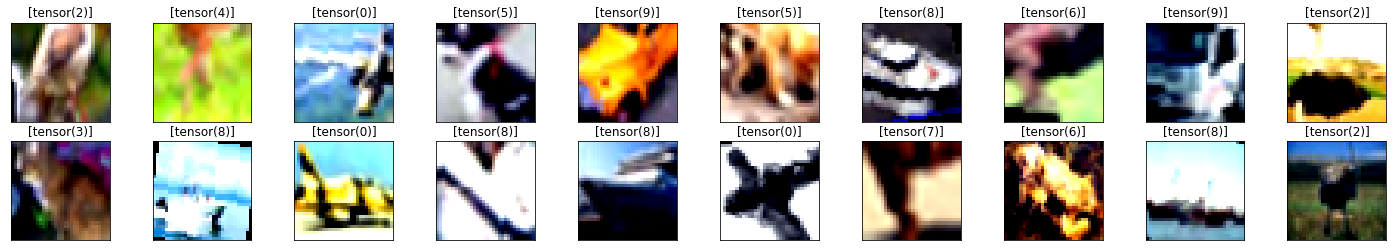

In [9]:
# Simple visuzlization for dataloaders to check what they are producing. 
train_dataiter = iter(train_loader)
images, labels = train_dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title([labels[idx]])

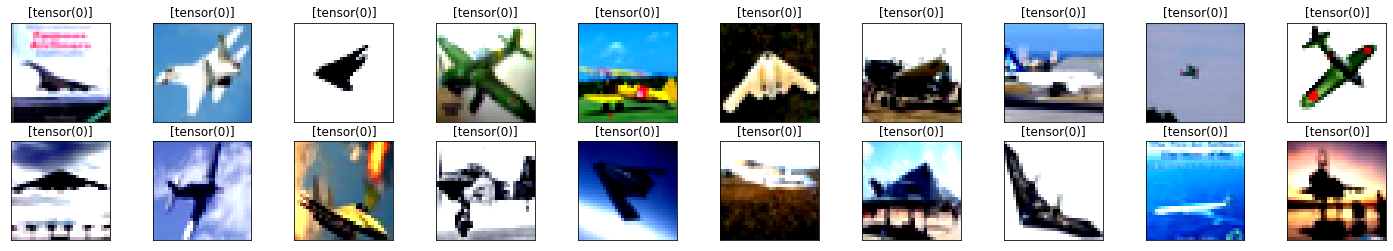

In [10]:
# Simple visuzlization for dataloaders to check what they are producing. 
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title([labels[idx]])

In [11]:

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = torch.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

In [12]:
use_gpu = torch.cuda.is_available()
print("IS there a GPU? : ", use_gpu)

IS there a GPU? :  True


In [13]:
# Build the Net
ae_model = ConvAutoencoder()
print(ae_model)
if use_gpu:
    ae_model.cuda()

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [14]:
# Loss and optimizers
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=3, verbose=True) # Automatically reduce learning rate on plateau

In [15]:
# number of epochs to train the model
n_epochs = 35
ae_model_filename = 'cifar_autoencoder.pt'
train_loss_min = np.Inf # track change in training loss

ae_train_loss_matrix = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        
        images, _ = data
        if use_gpu:
            images = images.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = ae_model(images)
        # calculate the loss
        loss = loss_function(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    scheduler.step(train_loss)
    ae_train_loss_matrix.append([train_loss, epoch])
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(ae_model.state_dict(), ae_model_filename)
        train_loss_min = train_loss

Epoch: 1 	Training Loss: 21.960548
Validation loss decreased (inf --> 21.960548).  Saving model ...
Epoch: 2 	Training Loss: 19.276410
Validation loss decreased (21.960548 --> 19.276410).  Saving model ...
Epoch: 3 	Training Loss: 18.915140
Validation loss decreased (19.276410 --> 18.915140).  Saving model ...
Epoch: 4 	Training Loss: 18.538170
Validation loss decreased (18.915140 --> 18.538170).  Saving model ...
Epoch: 5 	Training Loss: 18.387840
Validation loss decreased (18.538170 --> 18.387840).  Saving model ...
Epoch: 6 	Training Loss: 18.341115
Validation loss decreased (18.387840 --> 18.341115).  Saving model ...
Epoch: 7 	Training Loss: 18.255395
Validation loss decreased (18.341115 --> 18.255395).  Saving model ...
Epoch: 8 	Training Loss: 18.254484
Validation loss decreased (18.255395 --> 18.254484).  Saving model ...
Epoch: 9 	Training Loss: 18.285244
Epoch: 10 	Training Loss: 18.262850
Epoch: 11 	Training Loss: 18.187868
Validation loss decreased (18.254484 --> 18.187868)

In [16]:
# For plotting of the loss for the autoencoder
x, y = [], []
for i in range(len(ae_train_loss_matrix)):
    x.append(ae_train_loss_matrix[i][0])
    y.append(ae_train_loss_matrix[i][1])

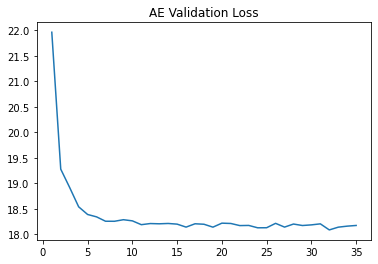

In [17]:
#plt.scatter(ae_train_loss_matrix[0],ae_train_loss_matrix[1])
plt.plot(y, x)
plt.title("AE Validation Loss")
plt.show()

In [18]:
# Load the best model with lowest loss
ae_model.load_state_dict(torch.load(ae_model_filename))

<All keys matched successfully>

(32, 3, 32, 32)


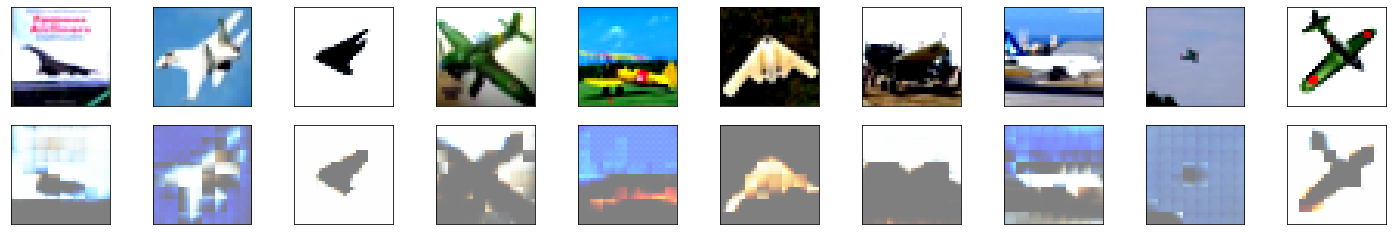

In [19]:
#Check how good the autoencoder is
# Check results
dataiter = iter(test_loader)
images, labels = dataiter.next()
if use_gpu:
    images = images.cuda()
# Get sample outputs
output = ae_model(images)
# Prep images for display
images = images.cpu()
images = images.numpy()
print(images.shape)
# use detach when it's an output that requires_grad
output = output.cpu()
output = output.detach().numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        img = img / 2 + 0.5  # unnormalize
        ax.imshow(np.transpose(img, (1, 2, 0))) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [20]:
for child in ae_model.children():
    print(child)
    
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        image_modules = list(ae_model.children())[:-2] #get only the encoder layers
        self.modelA = nn.Sequential(*image_modules)
        # Shape of max pool = 4, 112, 112
        self.fc1 = nn.Linear(4*16*16, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.out = nn.Linear(512, 10)
        
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.modelA(x)
        x = x.view(x.size(0),4*16*16)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = self.out(x)
        return x

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))


In [21]:
model = MyModel()
print(model)

MyModel(
  (modelA): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [22]:
def calc_accuracy(output,labels):
    max_vals, max_indices = torch.max(output,1)
    acc = (max_indices == labels).sum().item()/max_indices.size()[0]
    return acc

In [23]:
#Freze the autoencoder layers so they do not train. We did that already
# Train only the linear layers
for child in model.children():
    if isinstance(child, nn.Linear):
        print("Setting Layer {} to be trainable".format(child))
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


Setting Layer Linear(in_features=1024, out_features=1024, bias=True) to be trainable
Setting Layer Linear(in_features=1024, out_features=512, bias=True) to be trainable
Setting Layer Linear(in_features=512, out_features=10, bias=True) to be trainable


In [24]:
# Optimizer and Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-05)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [25]:
if use_gpu:
    model.cuda()
    
model_filename = 'model_cifar10.pt'
n_epochs = 40
valid_loss_min = np.Inf # track change in validation loss
train_loss_matrix = []
val_loss_matrix = []
val_acc_matrix = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_correct = 0
    train_total = 0
    
    val_correct = 0
    val_total = 0
    
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(validation_loader):
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        val_acc += calc_accuracy(output, target)
        
        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    #exp_lr_scheduler.step()
    scheduler.step(valid_loss)
    
    # Add losses and acc to plot latter
    train_loss_matrix.append([train_loss, epoch])
    val_loss_matrix.append([valid_loss, epoch])
    val_acc_matrix.append([val_acc, epoch])
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, val_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,valid_loss))
        
        torch.save(model.state_dict(), model_filename)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.242803 	Validation Loss: 2.066376	Validation Accuracy: 28.937500
Validation loss decreased (inf --> 2.066376).  Saving model ...
Epoch: 2 	Training Loss: 2.096495 	Validation Loss: 2.039764	Validation Accuracy: 29.614583
Validation loss decreased (2.066376 --> 2.039764).  Saving model ...
Epoch: 3 	Training Loss: 2.053732 	Validation Loss: 1.999026	Validation Accuracy: 31.833333
Validation loss decreased (2.039764 --> 1.999026).  Saving model ...
Epoch: 4 	Training Loss: 2.024066 	Validation Loss: 1.974075	Validation Accuracy: 31.968750
Validation loss decreased (1.999026 --> 1.974075).  Saving model ...
Epoch: 5 	Training Loss: 2.006377 	Validation Loss: 1.966369	Validation Accuracy: 33.916667
Validation loss decreased (1.974075 --> 1.966369).  Saving model ...
Epoch: 6 	Training Loss: 1.991759 	Validation Loss: 1.937378	Validation Accuracy: 34.229167
Validation loss decreased (1.966369 --> 1.937378).  Saving model ...
Epoch: 7 	Training Loss: 1.983084 	Vali

In [26]:
val_acc_x, val_loss_x, train_loss_x = [],[],[]
y = []
for i in range(len(train_loss_matrix)):
    train_loss_x.append(train_loss_matrix[i][0])
    y.append(train_loss_matrix[i][1])
for i in range(len(val_loss_matrix)):
    val_loss_x.append(val_loss_matrix[i][0])
for i in range(len(val_acc_matrix)):
    val_acc_x.append(val_acc_matrix[i][0])
    
print(len(val_acc_x), len(train_loss_x), len(val_loss_x), len(y))

40 40 40 40


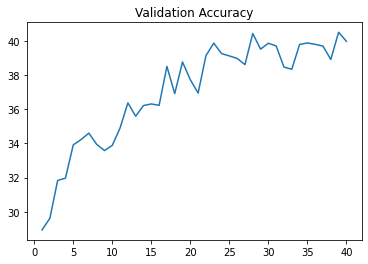

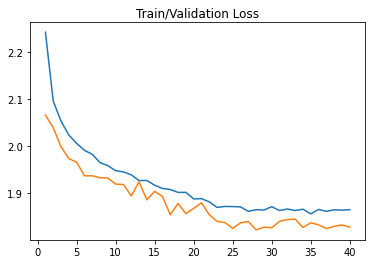

In [27]:
plt.plot(y, val_acc_x)
plt.title("Validation Accuracy")
plt.show()
plt.plot(y, train_loss_x)
plt.plot(y, val_loss_x)
plt.title("Train/Validation Loss")
plt.show()

In [28]:
# Load model with lowest validation loss
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

In [29]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if use_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.655620

Test Accuracy of airplane: 45% (231/504)
Test Accuracy of automobile: 61% (312/504)
Test Accuracy of  bird: 18% (91/496)
Test Accuracy of   cat: 11% (55/496)
Test Accuracy of  deer: 27% (139/504)
Test Accuracy of   dog: 35% (181/504)
Test Accuracy of  frog: 63% (315/496)
Test Accuracy of horse: 49% (244/496)
Test Accuracy of  ship: 59% (298/504)
Test Accuracy of truck: 46% (234/504)

Test Accuracy (Overall): 41% (2100/5008)
